<h1><center><font size="8">CNN Model for Tuberculosis Detection</font></center></h1>


# <a id='1'>Importing Packages</a>

In [1]:
import tensorflow as tf
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.13.0


In [14]:
# importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from keras import Model
from keras.models import load_model, Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from keras.metrics import AUC, Precision, Recall

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.utils import class_weight

import os

from utils import *

%reload_ext autoreload
%autoreload 2


# <a id='2'>Augmentation through ImageDataGenerator</a>


## <a id='21'>Generating the Datasets</a>
 

In [44]:
# generating augmentations through ImageDataGenerator
image_generator = ImageDataGenerator(rescale=1./255)


# assigning paths
train_folder = 'data/Tuberculosis/augmented_sorted/train'
val_folder = 'data/Tuberculosis/augmented_sorted/val'
test_folder = 'data/Tuberculosis/augmented_sorted/test'

train_generator = image_generator.flow_from_directory(train_folder, 
                                                      batch_size=16, 
                                                      shuffle=True, 
                                                      class_mode='binary',
                                                      target_size=(224, 224),
                                                      seed=42)

val_generator = image_generator.flow_from_directory(val_folder,
                                                    target_size=(224, 224),
                                                    batch_size = 16,
                                                    shuffle=True,
                                                    class_mode = 'binary',
                                                    seed = 42)

test_generator = image_generator.flow_from_directory(test_folder,
                                                     target_size = (224, 224),
                                                     batch_size = 1,
                                                     class_mode = 'binary',
                                                     shuffle=False, 
                                                     seed=42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = val_generator.n // val_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

Found 9822 images belonging to 2 classes.
Found 2456 images belonging to 2 classes.
Found 3289 images belonging to 1 classes.


In [16]:
# calculate class weights
total_tb = len(os.listdir(os.path.join(train_folder, 'TB')))
total_healthy = len(os.listdir(os.path.join(train_folder, 'Non-TB')))

weight_for_0 = total_tb / (total_healthy + total_tb)
weight_for_1 = total_healthy / (total_healthy + total_tb)

class_weights = {0: weight_for_0, 1: weight_for_1}
class_weights

{0: 0.38098147016900835, 1: 0.6190185298309917}

## <a id='22'>Constructing and Compiling the Model</a>


In [17]:
# create model
def create_model(input_shape):
    return Sequential([
        
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),   
        
        Flatten(),
        Dense(units=128, activation='relu'),
        Dropout(0.2),
        Dense(units=1, activation='sigmoid')
        ])

# save model
model = create_model((160, 160, 3))

# compile model
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01),
              metrics = ['accuracy', AUC(), AUC(curve='PR'), Precision(), Recall()])

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_12 (Ba  (None, 222, 222, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 220, 220, 32)      9248      
                                                                 
 batch_normalization_13 (Ba  (None, 220, 220, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 110, 110, 32)      0         
 g2D)                                                            
                                                      

## <a id='23'>Defining Callbacks</a>


In [19]:
# define callbacks
# earlyStopping = EarlyStopping(monitor = 'val_loss', 
#                               verbose = 1, 
#                               mode = 'min', 
#                               patience = 4)
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
filepath = "modeling/log_cnn1/model.{epoch:02d}-{val_loss:.2f}.hdf5"
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')
csv_logger = CSVLogger('modeling/log_cnn1/log.csv')
log_dir = "modeling/log_cnn1/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir = log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')


## <a id='24'>Training the Model</a>


In [20]:
# train model
history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = STEP_SIZE_TRAIN,
                              validation_data = val_generator,
                              validation_steps = STEP_SIZE_VALID,
                              epochs = 30,
                              class_weight = class_weights,
                              callbacks = [mcp_save, lr_reduction, csv_logger])

Epoch 1/30


2023-08-13 23:58:21.072131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


613/613 [==============================] - ETA: 0s - loss: 4359.4907 - accuracy: 0.6958 - auc_4: 0.6879 - auc_5: 0.5457 - precision_2: 0.5924 - recall_2: 0.6483

2023-08-14 00:00:23.288280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to modeling/log_cnn1/model.01-428231.53.hdf5
613/613 [==============================] - 154s 249ms/step - loss: 4359.4907 - accuracy: 0.6958 - auc_4: 0.6879 - auc_5: 0.5457 - precision_2: 0.5924 - recall_2: 0.6483 - val_loss: 428231.5312 - val_accuracy: 0.3815 - val_auc_4: 0.5000 - val_auc_5: 0.3815 - val_precision_2: 0.3815 - val_recall_2: 1.0000 - lr: 0.0100
Epoch 2/30
613/613 [==============================] - ETA: 0s - loss: 18543.2070 - accuracy: 0.7324 - auc_4: 0.7282 - auc_5: 0.5861 - precision_2: 0.6326 - recall_2: 0.7101
Epoch 2: saving model to modeling/log_cnn1/model.02-326410.25.hdf5
613/613 [==============================] - 152s 247ms/step - loss: 18543.2070 - accuracy: 0.7324 - auc_4: 0.7282 - auc_5: 0.5861 - precision_2: 0.6326 - recall_2: 0.7101 - val_loss: 326410.2500 - val_accuracy: 0.3766 - val_auc_4: 0.4901 - val_auc_5: 0.3768 - val_precision_2: 0.3768 - val_recall_2: 0.9690 - lr: 0.0100
Epoch 3/30
613/613 [==============================] - E

In [21]:
history = pd.read_csv("modeling/log_cnn1/log.csv")
history

,epoch,accuracy,auc_4,auc_5,loss,lr,precision_2,recall_2,val_accuracy,val_auc_4,val_auc_5,val_loss,val_precision_2,val_recall_2
0,0,0.695799,0.687889,0.545671,4359.490723,0.010000,0.592375,0.648302,0.381536,0.500000,0.381536,428231.531250,0.381536,1.000000
1,1,0.732409,0.728182,0.586132,18543.207031,0.010000,0.632570,0.710118,0.376634,0.490090,0.376844,326410.250000,0.376769,0.968951
2,2,0.756578,0.752431,0.615001,48399.503906,0.010000,0.662805,0.735011,0.669118,0.714968,0.530794,99306.750000,0.539147,0.907824
3,3,0.803386,0.801084,0.675088,35223.656250,0.010000,0.720477,0.791388,0.771242,0.791537,0.627352,39886.324219,0.647385,0.876609
4,4,0.836529,0.835331,0.720413,25464.148438,0.010000,0.761975,0.830300,0.856209,0.840389,0.767836,54456.011719,0.836616,0.773848
5,5,0.815113,0.814554,0.689921,38670.988281,0.010000,0.732095,0.812199,0.540033,0.618089,0.448737,320595.906250,0.450740,0.946409
6,6,0.791148,0.790447,0.657341,88981.218750,0.010000,0.700763,0.787513,0.631944,0.690807,0.505584,913130.125000,0.509861,0.940107
7,7,0.790026,0.790099,0.655450,127412.359375,0.010000,0.697823,0.790405,0.483660,0.526545,0.395811,256716.968750,0.398907,0.705693
8,8,0.815725,0.818637,0.688480,111656.398438,0.005000,0.725467,0.830880,0.845588,0.826346,0.753313,155912.843750,0.830144,0.746237
9,9,0.818682,0.819946,0.693535,105216.414062,0.005000,0.732716,0.825261,0.829657,0.804526,0.735852,214575.390625,0.827411,0.698821


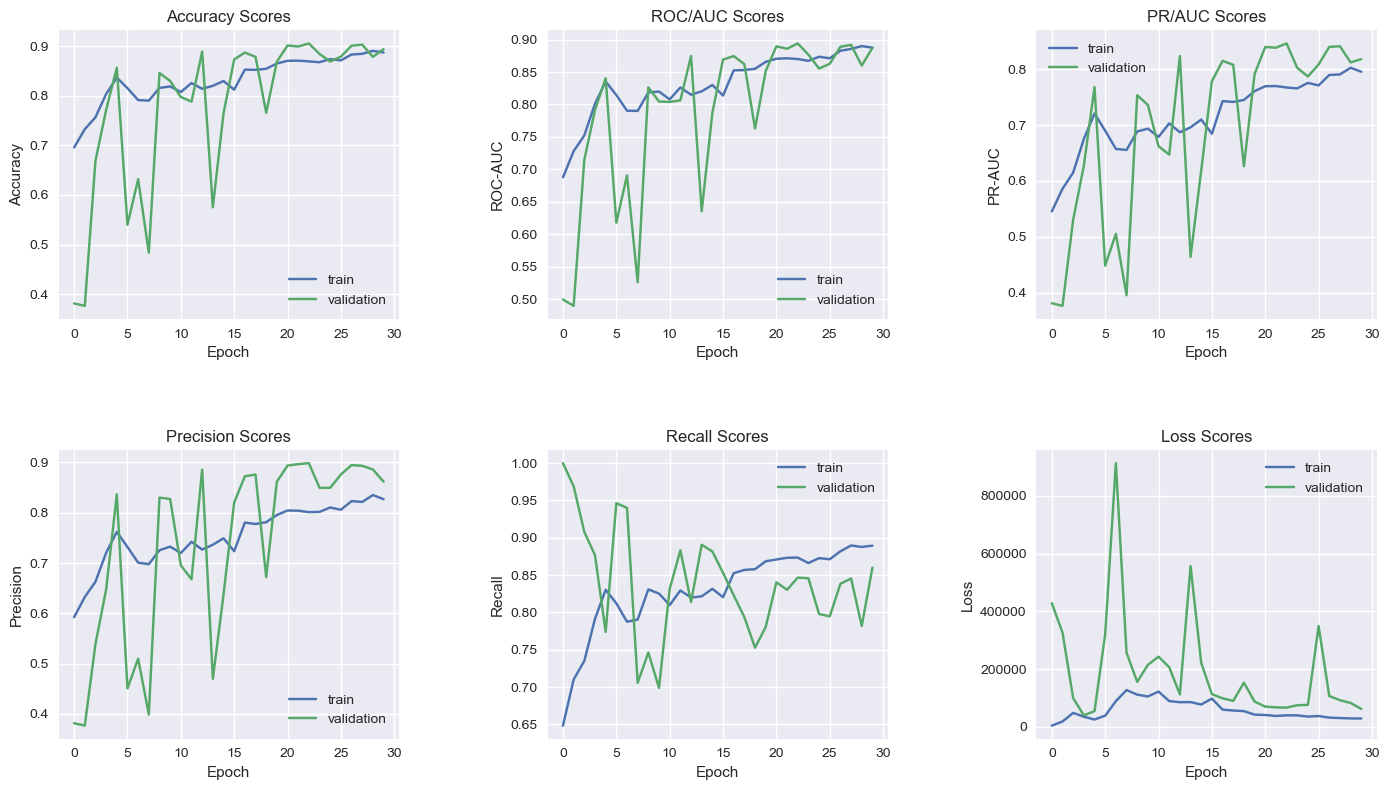

In [22]:
# evaluate model by displaying metrics with visualization
plt.style.use('seaborn')
sixplot2(history, 'auc_4', 'val_auc_4', 'auc_5', 'val_auc_5', 'precision_2', 'val_precision_2', 'recall_2', 'val_recall_2')

## Loading Best Model

In [ ]:
model_2 = load_model('../logs/log_cnn1a/model.16-0.15.hdf5')

## <a id='47'>Predicting on Holdout Set</a>

In [45]:
# get testing accuracy and loss
test_generator.reset()
score = model.evaluate_generator(test_generator, verbose = 1)

print("Loss: " + str(score[0]))
print("Accuracy: " + str(score[1]))
# print("Precision: " + str(score[2]))
# print("Recall: " + str(score[3]))
# print("ROC-AUC: " + str(score[4]))
# print("PR-AUC: " + str(score[5]))

3289/3289 [==============================] - 67s 20ms/step - loss: 367616.0312 - accuracy: 0.7498 - auc_4: 0.0000e+00 - auc_5: 0.0000e+00 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Loss: 367616.03125
Accuracy: 0.7497719526290894
Precision: 0.0
Recall: 0.0
ROC-AUC: 0.0
PR-AUC: 0.0


In [38]:
image_list = glob.glob('data/Tuberculosis/augmented_sorted/test/test/*.png')

In [39]:
def is_image_corrupted(image_path):
    try:
        # Try to open the image
        with Image.open(image_path) as img:
            img.verify()  # This method checks for corruption in the image
        return False  # Image is not corrupted
    except Exception as e:
        print(f"Image is corrupted: {e}")
        return True  # Image is corrupted

In [41]:
for image in image_list:
    if is_image_corrupted(image):
        print(image)
        os.remove(image)

Image is corrupted: cannot identify image file 'data/Tuberculosis/augmented_sorted/test/test/unknown_2576.png'
data/Tuberculosis/augmented_sorted/test/test/unknown_2576.png
Image is corrupted: cannot identify image file 'data/Tuberculosis/augmented_sorted/test/test/unknown_2210.png'
data/Tuberculosis/augmented_sorted/test/test/unknown_2210.png
Image is corrupted: cannot identify image file 'data/Tuberculosis/augmented_sorted/test/test/unknown_1719.png'
data/Tuberculosis/augmented_sorted/test/test/unknown_1719.png
Image is corrupted: cannot identify image file 'data/Tuberculosis/augmented_sorted/test/test/unknown_3126.png'
data/Tuberculosis/augmented_sorted/test/test/unknown_3126.png
Image is corrupted: cannot identify image file 'data/Tuberculosis/augmented_sorted/test/test/unknown_2238.png'
data/Tuberculosis/augmented_sorted/test/test/unknown_2238.png
Image is corrupted: cannot identify image file 'data/Tuberculosis/augmented_sorted/test/test/unknown_1731.png'
data/Tuberculosis/augmen

In [42]:
for image in image_list:
    if is_image_corrupted(image):
        print(image)

Image is corrupted: [Errno 2] No such file or directory: 'data/Tuberculosis/augmented_sorted/test/test/unknown_2576.png'
data/Tuberculosis/augmented_sorted/test/test/unknown_2576.png
Image is corrupted: [Errno 2] No such file or directory: 'data/Tuberculosis/augmented_sorted/test/test/unknown_2210.png'
data/Tuberculosis/augmented_sorted/test/test/unknown_2210.png
Image is corrupted: [Errno 2] No such file or directory: 'data/Tuberculosis/augmented_sorted/test/test/unknown_1719.png'
data/Tuberculosis/augmented_sorted/test/test/unknown_1719.png
Image is corrupted: [Errno 2] No such file or directory: 'data/Tuberculosis/augmented_sorted/test/test/unknown_3126.png'
data/Tuberculosis/augmented_sorted/test/test/unknown_3126.png
Image is corrupted: [Errno 2] No such file or directory: 'data/Tuberculosis/augmented_sorted/test/test/unknown_2238.png'
data/Tuberculosis/augmented_sorted/test/test/unknown_2238.png
Image is corrupted: [Errno 2] No such file or directory: 'data/Tuberculosis/augmented

3289/3289 [==============================] - 27s 8ms/step


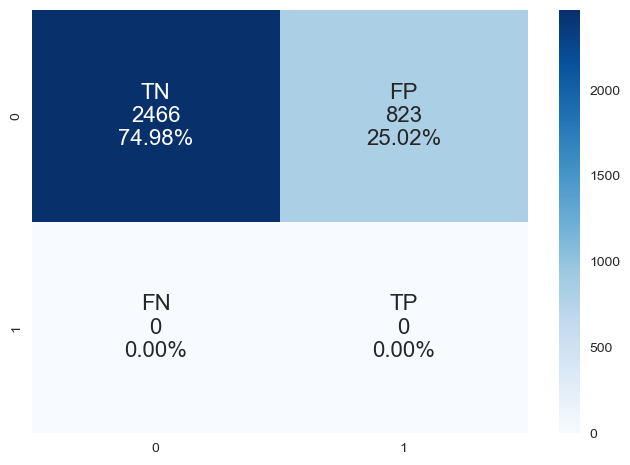

In [47]:
# visualization for confusion matrix
test_generator.reset()
pred = model.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
y_true = test_generator.classes
y_pred = pred > 0.5
make_confusion_matrix(y_true, y_pred)

## <a id='56'>Evaluating the Model</a>

In [ ]:
# create visualizations for training metrics
plt.style.use('seaborn')
history_3 = pd.read_csv("../logs/log_cnn/log.csv")
sixplot2(history_3, "auc", "val_auc", "auc_1", "val_auc_1", "precision", "val_precision", "recall", "val_recall")

In [ ]:
# display dataframe of training metrics
history_3

In [ ]:
# plot accuracy and loss visualizations
plt.style.use('seaborn')
train_val_metrics2(20, history_3)

## Loading Best Model

In [ ]:
model_3 = load_model('../logs/log_cnn/model.09-0.17.hdf5')

## <a id='58'>Predicting on Holdout Set</a>

In [ ]:
# display confusion matrix visualization
test_generator.reset()
pred_3 = model_3.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
y_true = test_generator.classes
y_pred_3 = pred_3 > 0.5
cf = confusion_matrix(y_true, y_pred_3)
draw_confusion_matrix(cf, ['TN','FP','FN','TP'], (5, 5), "Confusion Matrix for Simplified CNN Model")

In [ ]:
# get testing accuracy and loss
test_generator.reset()
score_3 = model_3.evaluate_generator(test_generator, verbose = 1)

print("Loss: " + str(score_3[0]))
print("Accuracy: " + str(score_3[1]))
print("Precision: " + str(score_3[2]))
print("Recall: " + str(score_3[3]))
print("ROC-AUC: " + str(score_3[4]))
print("PR-AUC: " + str(score_3[5]))

# Analysis

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier

In [ ]:
# create model
def create_model(input_shape):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))   
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid')

    return model

seed = 42
tf.random.set_seed(seed)    
    
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01),
              metrics = ['accuracy', AUC(), AUC(curve='PR'), Precision(), Recall()])    
              
filepath = "model.h5"
#Save weights into file
model.save_weights(filepath)
# save model
model = create_model((224, 224, 3))

# compile model
